Link: https://www.kaggle.com/competitions/telecom-churn-case-study-hackathon-c-65/


Problem statent

In In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

### 1. Data Import and Understanding


In [4]:
# Print package versions
from importlib.metadata import version
packages = ['numpy', 'pandas', 'matplotlib', 'seaborn']
for package in packages:
    print(f"{package}: {version(package)}")

numpy: 1.26.4
pandas: 2.1.4
matplotlib: 3.8.0
seaborn: 0.12.2


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
# Set environment settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [7]:
# Reading the dataset

train = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")

print("Dimension of the training dataset is", train.shape)
print("Dimension of the unseen dataset is", unseen.shape)

Dimension of the training dataset is (69999, 172)
Dimension of the unseen dataset is (30000, 171)


In [8]:
# Inspecting the train dataset
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [9]:
# Statistics summary of the train dataset
train.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

In [10]:
# Creating the copy of the original training set
telecom_df = train.copy()

In [11]:
# Creating the copy of the original test set
telecom_test_df = unseen.copy()

### 2. Data Cleaning and Preparation

#### 2.1. Checking the columns with single unique value

In [12]:
cols_with_single_value = []
for col in train.columns:
    if train[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [13]:
# Inspecting circle id
for col in cols_with_single_value:
    print(train[col].value_counts(dropna=False))
    print("--------------------------------------")

circle_id
109    69999
Name: count, dtype: int64
--------------------------------------
loc_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
std_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
loc_ic_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
--------------------------------------
last_date_of_month_7
7/31/2014    69600
NaN            399
Name: count, dtype: int64
--------------------------------------
last_date_of_month_8
8/31/2014    69266
NaN            733
Name: count, dtype: int64
--------------------------------------
std_og_t2c_mou_6
0.0    67231
NaN     2768
Name: count, dtype: int64
--------------------------------------
std_og_t2c_mou_7
0.0    67312
NaN     2687
Name: count, dtype: int64
--------------------------------------
std_og_t2c_mou_8
0.0    6

In [14]:
# Based on the dataset, we remove these columns from the training set
train.drop(cols_with_single_value, axis=1, inplace=True)

# Based on the dataset, we remove these columns from the test set
unseen.drop(cols_with_single_value, axis=1, inplace=True)

In [15]:
print(train['id'].nunique())
print(train['id'].shape)

69999
(69999,)


In [16]:
# Remove the id column since it is unique for every row from the training set
train.drop('id', axis=1, inplace=True)

# Remove the id column since it is unique for every row from the testing set
unseen.drop('id', axis=1, inplace=True)

In [17]:
# Generating a list of column names based on their corresponding types
date_cols = train.columns[train.columns.str.contains('date')]
cat_cols = train.columns[train.columns.str.contains('user')]

print(date_cols)
print(cat_cols)

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')
Index(['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6',
       'fb_user_7', 'fb_user_8'],
      dtype='object')


In [18]:
# Generating a list of numerical column names
numerical_cols = [col for col in train.columns if col not in date_cols + cat_cols]
print(numerical_cols)

['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'lo

In [19]:
# Dropping date columns as they are not useful for our analysis from the training set
train.drop(columns=date_cols, axis=1, inplace=True)

# Dropping date columns as they are not useful for our analysis from the test set
unseen.drop(columns=date_cols, axis=1, inplace=True)

In [20]:
### Check for columns with more than 70% missing values in the training dataset
mv_train_set = round(100*(train.isna().sum(axis=0)/train.shape[0]), 2)
mv_train_set[mv_train_set > 70].sort_values(ascending=False)

total_rech_data_6     74.90
arpu_3g_6             74.90
max_rech_data_6       74.90
fb_user_6             74.90
count_rech_2g_6       74.90
night_pck_user_6      74.90
count_rech_3g_6       74.90
arpu_2g_6             74.90
av_rech_amt_data_6    74.90
fb_user_7             74.48
night_pck_user_7      74.48
arpu_2g_7             74.48
arpu_3g_7             74.48
av_rech_amt_data_7    74.48
total_rech_data_7     74.48
count_rech_3g_7       74.48
count_rech_2g_7       74.48
max_rech_data_7       74.48
av_rech_amt_data_8    73.69
count_rech_3g_8       73.69
arpu_3g_8             73.69
count_rech_2g_8       73.69
arpu_2g_8             73.69
max_rech_data_8       73.69
night_pck_user_8      73.69
total_rech_data_8     73.69
fb_user_8             73.69
dtype: float64

#### 2.2 Missing value treatment
There are numerous variables with consistent percentages of missing data, suggesting a pattern of meaningful absence. Our strategy involves grouping similar data for analysis:

Grouping and treating missing values for 'recharge-related' data.
Grouping and treating missing values for 'ARPU' data.
Conducting missing value treatment on categorical columns.

In [21]:
# Columns with recharge information 
recharge_cols = train.columns[train.columns.str.contains('rech')]
print(recharge_cols)

# Columns with 'arpu' information 
arpu_cols = train.columns[train.columns.str.contains('arpu')]
print(arpu_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')
Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [22]:
print('\nTrain data handling\n')
# Replacing NaN values in recharge related columns with 0 in the training set
train[recharge_cols] = train[recharge_cols].fillna(0)
print(train[recharge_cols].isnull().sum()*100/train.shape[1])
# Replacing NaN values in ARPU related columns with 0 in the training set
train[arpu_cols] = train[arpu_cols].fillna(0)
print(train[arpu_cols].isnull().sum()*100/train.shape[1])

print('\nTest data handling\n')
# Replacing NaN values in recharge related columns with 0 in the test set
unseen[recharge_cols] = unseen[recharge_cols].fillna(0)
print(unseen[recharge_cols].isnull().sum()*100/unseen.shape[1])
# Replacing NaN values in ARPU related columns with 0 in the test set
unseen[arpu_cols] = unseen[arpu_cols].fillna(0)
print(unseen[arpu_cols].isnull().sum()*100/unseen.shape[1])


Train data handling

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64
arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64

Test data handling

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8    

In [23]:
# Inspecting categorical columns
train[cat_cols].value_counts()

night_pck_user_6  night_pck_user_7  night_pck_user_8  fb_user_6  fb_user_7  fb_user_8
0.0               0.0               0.0               1.0        1.0        1.0          9668
                                                      0.0        0.0        0.0           313
1.0               1.0               1.0               1.0        1.0        1.0           110
0.0               0.0               0.0               1.0        1.0        0.0            88
                                                      0.0        1.0        1.0            81
1.0               0.0               0.0               1.0        1.0        1.0            66
0.0               0.0               0.0               1.0        0.0        1.0            51
                  1.0               0.0               1.0        1.0        1.0            48
                  0.0               0.0               1.0        0.0        0.0            47
                                                      0.0        0.0

In [24]:
print('\nTrain data handling\n')

# Replacing NaN values in categorical related columns with -1. Converting datatypes from `float64` to 'category'.
train[cat_cols] = train[cat_cols].fillna(-1).astype('category')
print(train[cat_cols].isnull().sum()*100/train.shape[1])

# Verifying the change in dtype on the train set
train[cat_cols].info()

print('\nTest data handling\n')

# Replacing NaN values in categorical related columns with -1. Converting datatypes from `float64` to 'category'.
unseen[cat_cols] = unseen[cat_cols].fillna(-1).astype('category')
print(unseen[cat_cols].isnull().sum()*100/unseen.shape[1])

# Verifying the change in dtype on the test set
unseen[cat_cols].info()


Train data handling

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.1 KB

Test data handling

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 column

In [25]:
# Checking for the columns which have missing values present
mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].sort_values(ascending=False)

ic_others_8         5.29
loc_og_t2m_mou_8    5.29
std_og_mou_8        5.29
spl_og_mou_8        5.29
std_og_t2f_mou_8    5.29
og_others_8         5.29
std_og_t2m_mou_8    5.29
loc_ic_t2t_mou_8    5.29
std_og_t2t_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_og_mou_8        5.29
loc_ic_t2f_mou_8    5.29
loc_og_t2c_mou_8    5.29
loc_ic_mou_8        5.29
isd_og_mou_8        5.29
std_ic_t2t_mou_8    5.29
loc_og_t2f_mou_8    5.29
std_ic_t2m_mou_8    5.29
spl_ic_mou_8        5.29
onnet_mou_8         5.29
loc_og_t2t_mou_8    5.29
std_ic_t2f_mou_8    5.29
isd_ic_mou_8        5.29
roam_og_mou_8       5.29
std_ic_mou_8        5.29
offnet_mou_8        5.29
roam_ic_mou_8       5.29
ic_others_6         3.95
og_others_6         3.95
loc_ic_t2t_mou_6    3.95
isd_ic_mou_6        3.95
spl_ic_mou_6        3.95
loc_ic_t2m_mou_6    3.95
std_ic_t2m_mou_6    3.95
loc_ic_t2f_mou_6    3.95
loc_ic_mou_6        3.95
std_ic_mou_6        3.95
std_ic_t2t_mou_6    3.95
std_ic_t2f_mou_6    3.95
spl_og_mou_6        3.95


In [26]:
# Creating a list containing these columns to be processed later.
missing_values_list = mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].index
print(missing_values_list)

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [27]:
train[missing_values_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 81 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   onnet_mou_6       67231 non-null  float64
 1   onnet_mou_7       67312 non-null  float64
 2   onnet_mou_8       66296 non-null  float64
 3   offnet_mou_6      67231 non-null  float64
 4   offnet_mou_7      67312 non-null  float64
 5   offnet_mou_8      66296 non-null  float64
 6   roam_ic_mou_6     67231 non-null  float64
 7   roam_ic_mou_7     67312 non-null  float64
 8   roam_ic_mou_8     66296 non-null  float64
 9   roam_og_mou_6     67231 non-null  float64
 10  roam_og_mou_7     67312 non-null  float64
 11  roam_og_mou_8     66296 non-null  float64
 12  loc_og_t2t_mou_6  67231 non-null  float64
 13  loc_og_t2t_mou_7  67312 non-null  float64
 14  loc_og_t2t_mou_8  66296 non-null  float64
 15  loc_og_t2m_mou_6  67231 non-null  float64
 16  loc_og_t2m_mou_7  67312 non-null  float6

#### 2.3. Analysing our target variable churn_probability

In [28]:
train['churn_probability'].dtype

dtype('int64')

In [29]:
train['churn_probability'] = train['churn_probability'].astype('category')

In [30]:
# Verify the new dtype
train['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [31]:
# Check the value counts of churn and not-churn
print(train['churn_probability'].value_counts())
print('-------------------------------------------------')

# Calculate churn ratio
print('Churn ratio:')
print(train['churn_probability'].value_counts()*100/train.shape[0])

churn_probability
0    62867
1     7132
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    89.811283
1    10.188717
Name: count, dtype: float64


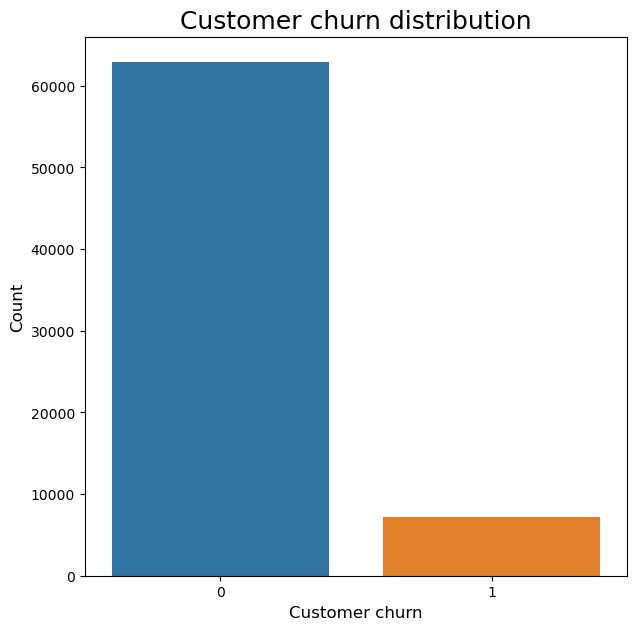

In [32]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = train['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

#### 2.4. Impute missing values using KNN Imputer - Training Set

In [33]:
train.shape

(69999, 152)

In [34]:
# Get the list of columns with missing values in the training set
mv = round(100*(train.isnull().sum(axis=0)/train.shape[0]), 2)
s = mv.loc[mv>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [35]:
print(impute_cols_num)

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic

In [36]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [37]:
# Separate df having columns to be imputed
df_num = train[impute_cols_num]
train_df = train.drop(impute_cols_num, axis=1)

In [38]:
%%time
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

CPU times: total: 10min 5s
Wall time: 10min 6s


In [39]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00
1,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00
2,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25
3,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,0.0,1.63,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63,0.26,12.06,0.00,15.33,25.93,4.6,0.56,0.0,0.0,16.16,37.99,4.60,0.0,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,24.98,4.84,23.88,53.99,44.23,57.14,7.23,0.81,0.00,86.21,49.89,81.03,0.00,0.00,0.00,8.89,0.28,2.81,0.0,0.0,0.0,8.89,0.28,2.81,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00
4,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.00,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.0,0.00,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00


In [40]:
# Merge the two dataframes together post imputation to create the final training set
train_final = pd.concat([df_imp, train_df], join='inner', axis=1)
train_final.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,7.46,27.58,15.18,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,31.277,87.009,7.527,81.21,221.68,3.63,11.84,53.04,40.56,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1958,0.0,0.0,0.0,0
1,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,0.000,122.787,42.953,0.00,30.73,31.66,3.44,39.44,25.04,3,4,5,0,145,50,0,145,50,0,0,0,0.0,1.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,145.0,0.0,0.0,352.91,0.00,0.0,3.96,0.0,0.0,122.07,0.0,0.0,122.08,0.0,-1.0,0.0,-1.0,0,0,0,0,0,0,0,1,0,0,0,0,-1.0,1.0,-1.0,710,0.0,0.0,0.0,0
2,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,29.91,2.48,6.38,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,60.806,103.176,0.000,56.49,99.36,0

In [41]:
train_final.shape

(69999, 152)

In [42]:
# Verify no missing value is present in the training set now
train_final.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_data_8     0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
total_rech_data_6     0
total_rech_data_7     0
max_rech_data_6       0
onnet_mou_7           0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
max_rech_amt_6        0
total_rech_amt_8      0
total_rech_amt_7      0
total_rech_amt_6      0
ic_others_6           0
ic_others_7           0
ic_others_8           0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
total_rech_num_7      0
total_rech_num_8      0
count_rech_3g_8       0
av_rech_amt_data_6    0
av_rech_amt_data_7    0
monthly_2g_8          0
sachet_2g_7     

#### 2.5. Impute missing values using KNN Imputer - Testing Set

In [43]:
# Separate df having columns to be imputed
df_num_test = unseen[impute_cols_num]
test_df = unseen.drop(impute_cols_num, axis=1)

In [44]:
%%time
# Impute using KNN imputer instance
df_imp_test = imputer.transform(df_num_test)

CPU times: total: 4min 16s
Wall time: 4min 14s


In [45]:
# Convert it to df post imputation
df_imp_test = pd.DataFrame(df_imp_test, columns=impute_cols_num)
df_imp_test.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8
0,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00
1,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00
2,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00
3,5.31,2.16,0.00,40.04,205.01,24.01,0.00,0.00,0.00,0.00,0.00,0.00,5.31,0.00,0.00,2.94,98.61,20.51,0.00,0.00,2.35,0.0,6.18,0.00,8.26,98.61,22.86,0.00,2.16,0.00,37.09,94.36,0.00,0.0,0.0,0.0,37.09,96.53,0.00,0.0,0.0,0.0,0.00,12.03,1.15,0.0,0.0,0.0,58.11,54.64,23.04,487.94,449.83,506.94,0.00,0.38,1.64,546.06,504.86,531.64,0.00,4.26,0.00,9.63,11.88,8.83,0.0,0.0,0.00,9.63,16.14,8.83,0.00,0.00,0.00,0.00,1.43,8.65,0.0,0.0,0.00
4,450.93,609.03,700.68,60.94,23.84,74.16,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.78,14.56,2.39,2.66,10.94,0.00,0.00,0.00,0.0,0.00,0.00,2.84,3.44,25.51,450.48,608.24,686.11,58.54,21.18,63.18,0.0,0.0,0.0,509.03,629.43,749.29,0.0,0.0,0.0,0.71,5.39,4.96,2.2,0.0,0.0,0.00,0.36,9.91,10.13,9.23,7.69,0.00,0.00,0.00,10.13,9.59,17.61,29.71,92.36,107.39,13.88,13.96,32.46,0.0,0.0,1.61,43.59,106.33,141.48,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.16


In [46]:
# Merge the two dataframes together post imputation
test_final = pd.concat([df_imp_test, test_df], join='inner', axis=1)
test_final.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,91.882,65.330,64.445,91.94,52.39,57.94,41.73,43.56,36.26,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,1692,0.00,0.00,0.00
1,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,414.168,515.568,360.868,549.86,663.06,415.59,296.33,339.64,281.66,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,-1.0,-1.0,-1.0,2533,0.00,0.00,0.00
2,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,3

In [47]:
test_final.shape

(30000, 151)

In [48]:
# Verify no missing value is present in the test set now
test_final.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_8      0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
total_rech_data_6     0
total_rech_data_7     0
total_rech_data_8     0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
max_rech_amt_6        0
total_rech_amt_7      0
count_rech_3g_8       0
total_rech_amt_6      0
ic_others_6           0
ic_others_7           0
ic_others_8           0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
total_rech_num_7      0
total_rech_num_8      0
count_rech_3g_7       0
av_rech_amt_data_6    0
isd_ic_mou_7          0
monthly_2g_7          0
sachet_2g_6           0
sachet_2g_7     

### 3. Utility functions

In [49]:
def calculate_classification_metrics(y_true, y_pred):
    """
    Calculate various classification metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: A DataFrame containing the calculated metrics.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = sensitivity

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df

In [50]:
def plot_bar_graph(title, month, y_list, data):
    """
    Plot bar graphs for given data.

    Parameters:
    - title (str): Title of the plot.
    - month (list of str): List of month names.
    - y_list (list of str): List of y-variable names corresponding to each month.
    - data (DataFrame): DataFrame containing the data to be plotted.

    Returns:
    - None

    This function plots bar graphs for each month's data based on the provided y-variables.
    It creates subplots for each month, with the corresponding y-variable plotted against 'churn_probability'.
    The title of each subplot includes the specified title along with the month name.
    """
    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
    
    plt.tight_layout()
    plt.show()

In [51]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

### 4. Exploratory Data Analysis (EDA)


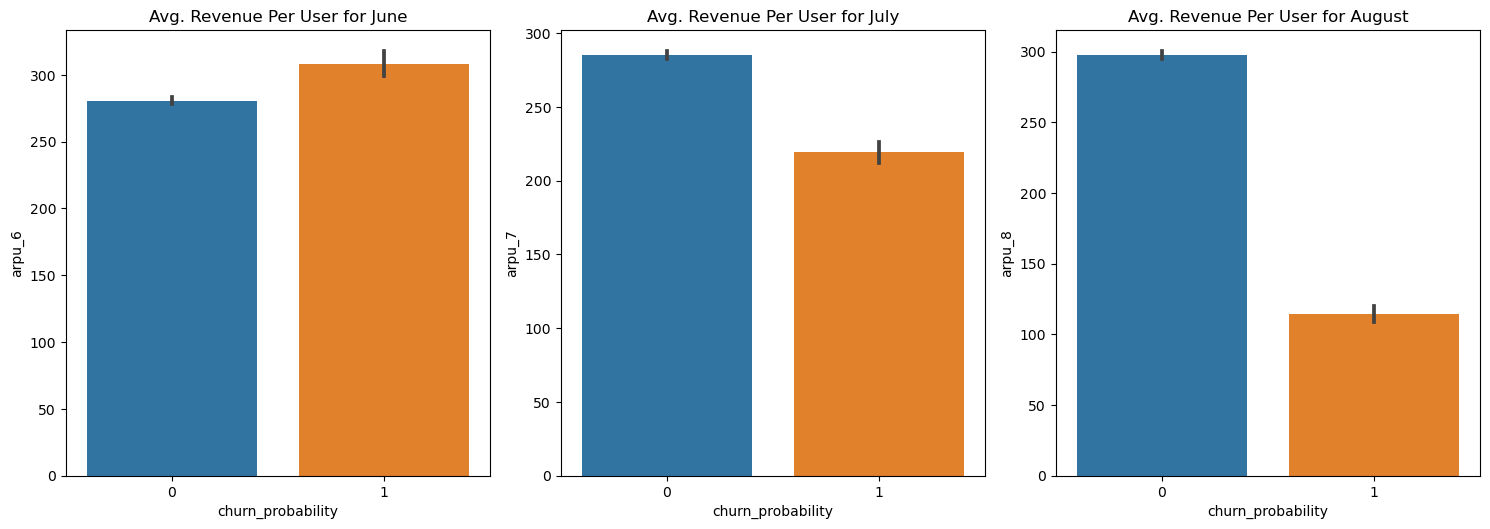

In [52]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, train_final)

The decline in the Average Revenue Per User (ARPU) in month of August suggests churn.

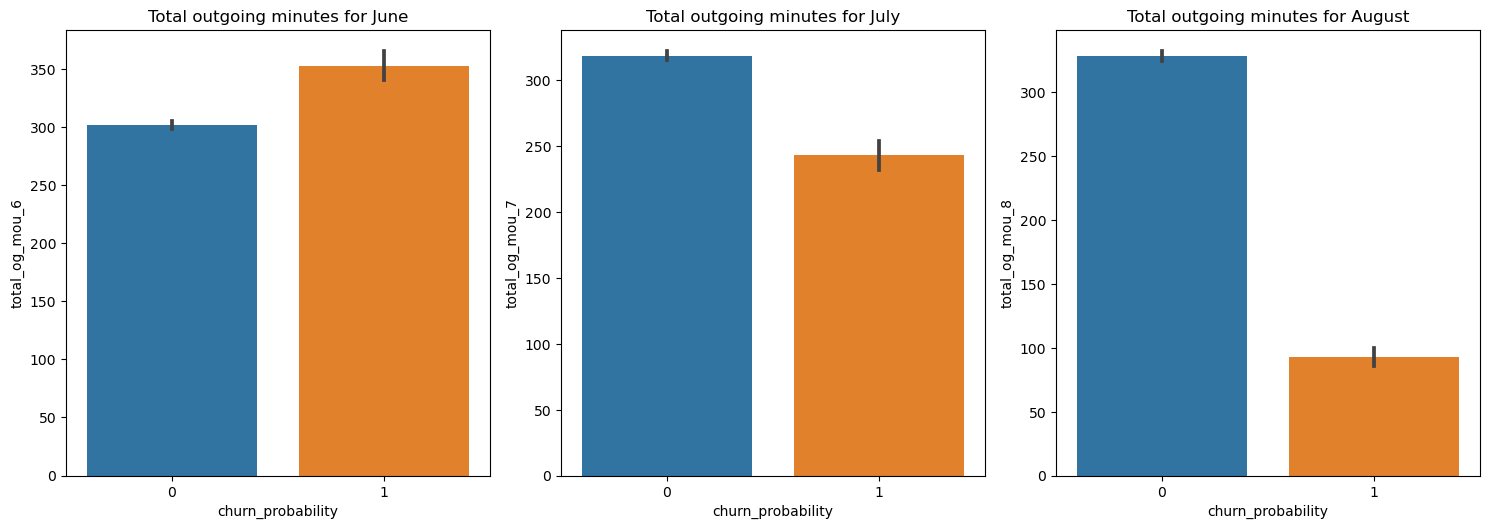

In [53]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, train_final)

The decline in the Total outgoing minutes in month of August suggests churn.

In [54]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = train_final.loc[:, train_final.columns.str.contains('amt')]
data2g = train_final.loc[:, train_final.columns.str.contains('2g')]
data3g = train_final.loc[:, train_final.columns.str.contains('3g')]
ic_mou_data = train_final.loc[:, train_final.columns.str.contains('ic') & train_final.columns.str.contains('mou')]
net_mou_data = train_final.loc[:, train_final.columns.str.contains('net_mou')]
og_mou_data = train_final.loc[:, train_final.columns.str.contains('og') & train_final.columns.str.contains('mou')]
rech_data = train_final.loc[:, train_final.columns.str.contains('rech')]
total_data = train_final.loc[:, train_final.columns.str.contains('tot')]

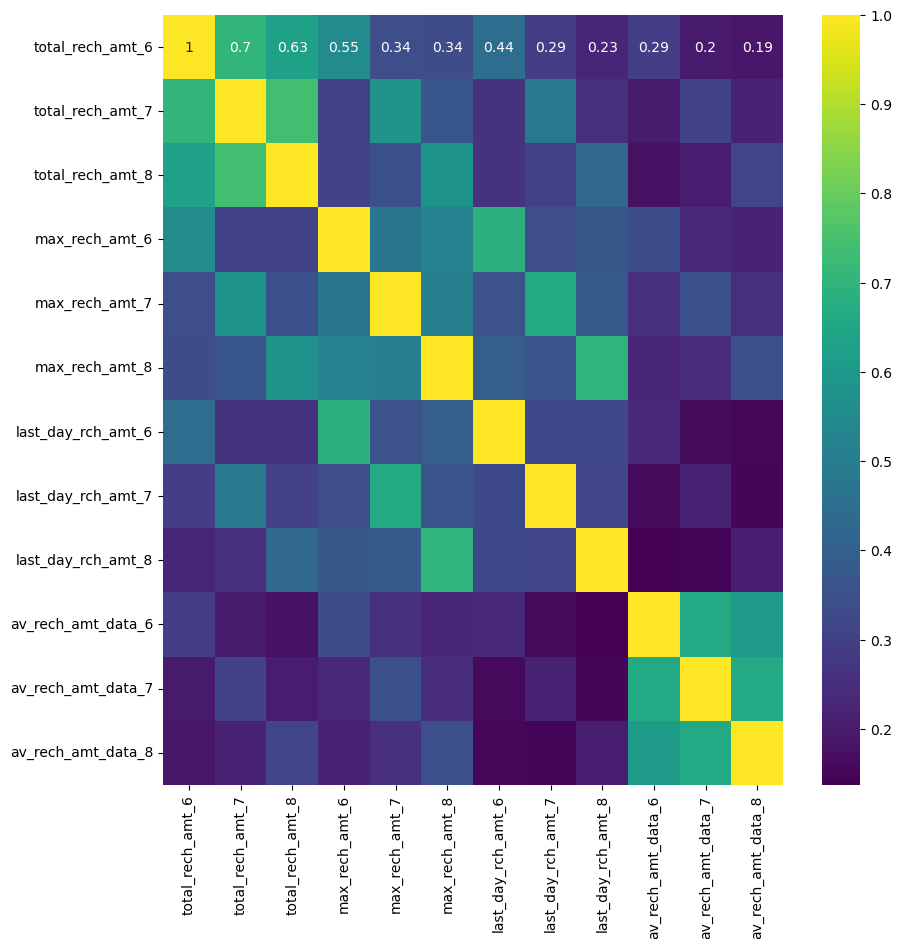

In [55]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

Observations:

A substantial correlation of 74% exists between the total recharge amount in month 7 and month 8.
Similarly, a notable correlation of 68% is observed between the maximum recharge amount in month 8 and the last day's recharge amount in the same month.
This suggests that customers who are unlikely to churn tend to recharge higher amounts in month 8.

### 5. Dummy Variable Encoding

In [56]:
print(train_final[cat_cols].columns)
print(train_final[cat_cols].nunique())
trdummy = pd.get_dummies(train_final[cat_cols], drop_first=True, dtype='int')
tr_final = pd.concat([train_final, trdummy], axis=1)
print(tr_final.shape)
print(test_final[cat_cols].columns)
print(test_final[cat_cols].nunique())
tedummy = pd.get_dummies(test_final[cat_cols], drop_first=True, dtype='int')
te_final = pd.concat([test_final, tedummy], axis=1)
print(te_final.shape)

Index(['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6',
       'fb_user_7', 'fb_user_8'],
      dtype='object')
night_pck_user_6    3
night_pck_user_7    3
night_pck_user_8    3
fb_user_6           3
fb_user_7           3
fb_user_8           3
dtype: int64
(69999, 164)
Index(['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6',
       'fb_user_7', 'fb_user_8'],
      dtype='object')
night_pck_user_6    3
night_pck_user_7    3
night_pck_user_8    3
fb_user_6           3
fb_user_7           3
fb_user_8           3
dtype: int64
(30000, 163)


In [57]:
# Creating dummies for categorical columns
train_dummy = pd.get_dummies(train_final[cat_cols], drop_first=True, dtype='int')
train_final = pd.concat([train_final, train_dummy], axis=1)

In [58]:
print(train_final.info())
print(train_final.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 164 entries, onnet_mou_6 to fb_user_8_1.0
dtypes: category(7), float64(120), int32(12), int64(25)
memory usage: 81.1 MB
None
(69999, 164)


In [59]:
# Creating dummies for categorical columns
test_dummy = pd.get_dummies(test_final[cat_cols], drop_first=True, dtype='int')
test_final = pd.concat([test_final, test_dummy], axis=1)

In [60]:
print(test_final.info())
print(test_final.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 163 entries, onnet_mou_6 to fb_user_8_1.0
dtypes: category(6), float64(120), int32(12), int64(25)
memory usage: 34.7 MB
None
(30000, 163)


### 8. Model Building and Evaluation

#### 8.1 Train-Test Split

In [61]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = train_final.drop(['churn_probability'], axis=1)
y = train_final['churn_probability']

In [62]:
print(X.shape)
print(y.shape)

(69999, 163)
(69999,)


In [63]:
# Train test split - 80% training data, 20% validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=100)

In [64]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)

X_train Shape: (55999, 163)
y_train Shape: (55999,)
X_val Shape: (14000, 163)
y_val Shape: (14000,)


In [65]:
y_train.value_counts()

churn_probability
0    50259
1     5740
Name: count, dtype: int64

#### 8.2. Feature Scaling using SandardScaler

In [66]:
## Train data

# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)

# Only Transform validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns, index = X_val.index)

X_train_scaled.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,night_pck_user_6_0.0,night_pck_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_6_0.0,fb_user_6_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_8_0.0,fb_user_8_1.0
59805,-0.332752,-0.246214,-0.430044,-0.131321,-0.200101,-0.611847,-0.163152,-0.127351,-0.132236,-0.175508,-0.169660,-0.150952,-0.292426,0.075191,-0.295459,-0.351696,0.280549,-0.597307,-0.283474,-0.284343,-0.280647,-0.137312,-0.174588,-0.224570,-0.416086,0.207532,-0.572838,-0.193848,-0.317002,-0.317750,0.125357,-0.347799,-0.342995,-0.134575,-0.126122,-0.135167,-0.048506,-0.436392,-0.435488,-0.027989,-0.026698,-0.029214,-0.220833,-0.223745,-0.295803,-0.065767,-0.014309,-0.014600,-0.340859,-0.316395,-0.331870,-0.560832,-0.268552,-0.656875,-0.309230,-0.291155,-0.301335,-0.612923,-0.407646,-0.669783,-0.188464,-0.179844,-0.190588,0.529050,-0.267317,-0.274107,-0.12575,-0.132979,-0.126212,0.282506,-0.309091,-0.317386,0.325453,-0.240187,-0.280924,-0.084423,-0.129142,-0.133830,-0.072309,-0.076247,-0.076468,-0.768898,0.507190,-0.769612,-0.659638,-0.251981,-0.634036,-0.693072,-0.474795,-0.691403,-1.070327,-0.947629,-0.724537,-0.793292,-0.769220,-0.735347,-0.853311,-0.857460,-0.860033,-0.640040,-0.617387,-0.613925,-0.352579,-0.353930,-0.355083,-0.406864,-0.411383,-0.414802,-0.310307,-0.314414,-0.320232,-0.215464,-0.209382,-0.209032,-0.379001,-0.388028,-0.389927,-0.248675,-0.243972,-0.23686,-0.218024,-0.22973,-0.234240,-0.213167,-0.213324,-0.223019,-0.229139,-0.224485,-0.234591,-0.570942,-0.577755,-0.588103,-0.268239,-0.273015,-0.269532,-0.262939,-0.268468,-0.27573,-0.209883,-0.201927,-0.212607,-0.128093,-0.127708,-0.124883,-0.571648,-0.577412,-0.585055,-0.463407,-0.252737,-0.246090,-0.23044,-0.570071,-0.078849,-0.576972,-0.076993,-0.587475,-0.073144,-0.146779,-0.547093,-0.153373,-0.550646,-0.171003,

In [67]:
## Test data

# Transform unseen data set
#X_test_scaled = pd.DataFrame(scaler.transform(test_final), columns = test_final.columns, index = test_final.index)

#### 8.4. Model 1. Logistic Regression with Recursive Feature Elimination (RFE)


In [68]:
%%time
# Select top 20 features using RFE
logreg = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train)

CPU times: total: 46min
Wall time: 49min 20s


In [69]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 85),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 84),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 59),
 ('roam_ic_mou_7', False, 102),
 ('roam_ic_mou_8', False, 121),
 ('roam_og_mou_6', False, 86),
 ('roam_og_mou_7', False, 88),
 ('roam_og_mou_8', False, 41),
 ('loc_og_t2t_mou_6', False, 68),
 ('loc_og_t2t_mou_7', False, 53),
 ('loc_og_t2t_mou_8', False, 100),
 ('loc_og_t2m_mou_6', False, 115),
 ('loc_og_t2m_mou_7', False, 127),
 ('loc_og_t2m_mou_8', False, 37),
 ('loc_og_t2f_mou_6', False, 75),
 ('loc_og_t2f_mou_7', False, 74),
 ('loc_og_t2f_mou_8', False, 67),
 ('loc_og_t2c_mou_6', False, 83),
 ('loc_og_t2c_mou_7', False, 128),
 ('loc_og_t2c_mou_8', False, 71),
 ('loc_og_mou_6', False, 25),
 ('loc_og_mou_7', False, 69),
 ('loc_og_mou_8', False, 40),
 ('std_og_t2t_mou_6', False, 27),
 ('std_og_t2t_mou_7', False, 87),
 ('std_og_t2t_mou_8', False, 4),
 ('std_og_t2m_mou_6', False, 26),
 ('std

In [70]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'offnet_mou_8',
       'std_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_8', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_7',
       'total_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8',
       'fb_user_8_1.0'],
      dtype='object')

In [71]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg.fit(X_train_scaled_final, y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [72]:
y_train_pred = logreg.predict(X_train_scaled_final)

In [73]:
# Calculate metrics on the training set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[49730   529]
 [ 3736  2004]]


,Metric,Value
0,Accuracy,0.9238
1,Sensitivity,0.3491
2,Specificity,0.9895
3,Precision,0.7912
4,False Positive Rate,0.0105
5,True Positive Rate,0.3491


In [74]:
# Retain only the selected feature from the final model
X_val_scaled_final = X_val_scaled[selected_features]
X_val_scaled_final.head()

,onnet_mou_7,onnet_mou_8,offnet_mou_7,offnet_mou_8,std_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,total_og_mou_7,total_og_mou_8,total_ic_mou_7,total_ic_mou_8,total_rech_num_8,last_day_rch_amt_8,fb_user_8_1.0
3425,1.261801,-0.430044,1.971922,-0.606980,-0.435488,-0.331870,-0.648170,-0.664051,-0.190588,-0.274107,-0.317386,-0.280924,-0.096866,2.166393,-0.630782,-0.395540,-0.678573,-0.724537,-0.613925,-0.551913
33067,0.479463,-0.346578,0.647158,-0.308063,-0.435488,-0.331870,-0.656875,-0.669783,-0.190588,-0.274107,-0.317386,-0.280924,-0.133830,0.395215,-0.634036,-0.198419,-0.691613,-0.031021,-0.613925,-0.551913
52420,-0.343807,-0.430044,-0.611501,-0.609102,-0.435488,-0.331870,-0.656875,-0.669783,-0.190588,-0.274107,-0.317386,-0.280924,-0.133830,-0.647560,-0.634036,-0.683399,-0.691613,-0.724537,-0.613925,-0.551913
5220,-0.432510,-0.430044,-0.613790,-0.611847,-0.435488,-0.329158,-0.595694,-0.615823,-0.190588,-0.274107,-0.317386,-0.280924,-0.133830,-0.621903,-0.634036,-0.665075,-0.645534,-0.863241,0.350044,1.811879
33958,-0.334526,-0.366997,-0.068926,-0.510991,-0.337294,-0.251361,-0.643445,-0.614758,0.034368,-0.274107,-0.205382,-0.280924,-0.133830,-0.221252,-0.539884,-0.517471,-0.604420,-0.585834,-0.613925,-0.551913


In [75]:
# Get the predicted values from the linear model
y_val_pred = logreg.predict(X_val_scaled_final)

In [76]:
confusion = confusion_matrix(y_true=y_val, y_pred=y_val_pred)
print(confusion)

[[12496   112]
 [  920   472]]


In [77]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_true=y_val, y_pred=y_val_pred)
metrics_df

Confusion Matrix

[[12496   112]
 [  920   472]]


,Metric,Value
0,Accuracy,0.9263
1,Sensitivity,0.3391
2,Specificity,0.9911
3,Precision,0.8082
4,False Positive Rate,0.0089
5,True Positive Rate,0.3391


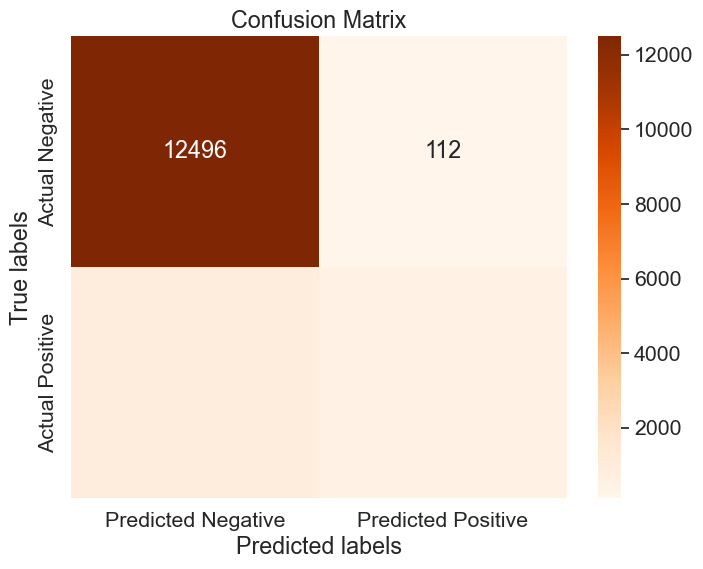

In [78]:
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape the confusion matrix into a 2x2 array
cm_array = np.array(confusion).reshape(2,2)

# Create the heatmap
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(cm_array, annot=True, cmap='Oranges', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

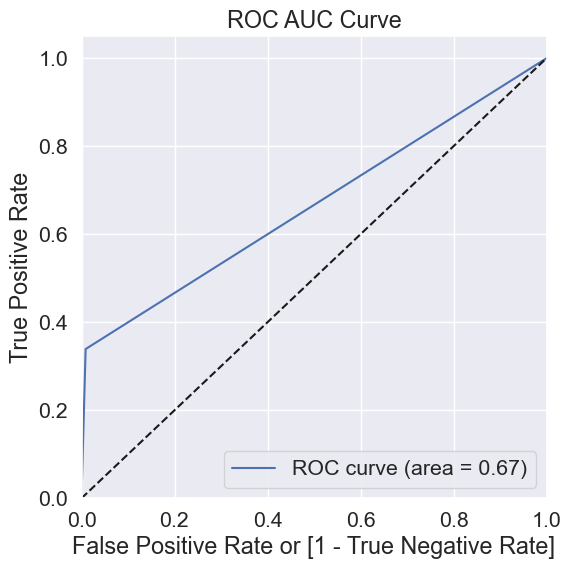

In [79]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [80]:
# ROC AUC Score
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.67'

#### 8.5. Model 2. Logistic Regression with PCA and Hyperparameter Tuning

In [81]:
pca = PCA()

In [82]:
pca_components = pca.fit_transform(X_train)
pca_components

array([[-8.58550347e+02, -5.30869966e+02,  2.17554122e+02, ...,
         6.27874333e-13, -1.15356357e-13,  1.49891281e-13],
       [-1.08138572e+01,  2.48349949e+02, -5.06389234e+02, ...,
         6.45540967e-13, -4.34374494e-13, -2.54254012e-13],
       [ 1.30848900e+02,  1.41129055e+03,  1.12898478e+03, ...,
         3.58696304e-13,  4.60025400e-13, -3.06479955e-14],
       ...,
       [-6.76057013e+02,  5.01764949e+02, -7.09013747e+02, ...,
         1.39404282e-14,  4.72631775e-14,  2.27668675e-14],
       [-1.77533097e+02,  8.66598237e+02,  8.88969281e+02, ...,
         4.05042569e-14, -1.16359289e-13,  5.79200726e-16],
       [ 1.40281243e+03,  1.99582619e+03, -1.94697215e+03, ...,
        -1.70482774e-13, -8.88775628e-14, -1.23787498e-14]])

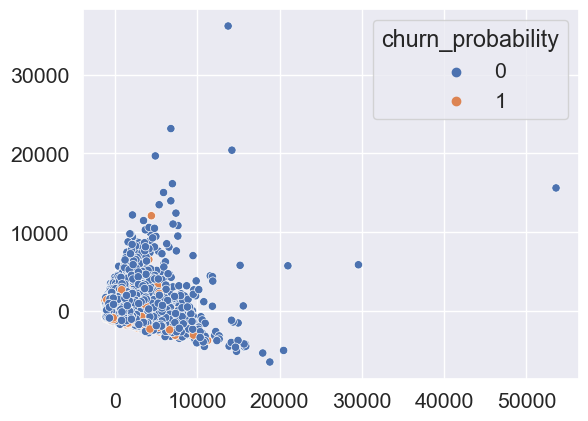

In [83]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

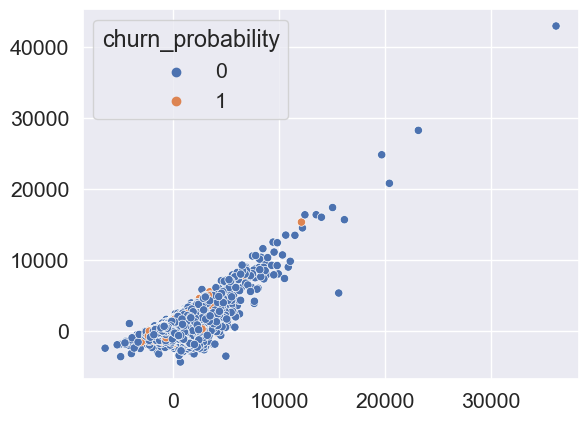

In [84]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

In [86]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=20)
lr = LogisticRegression(max_iter=1000, tol=0.001, random_state=42)

In [87]:
pipe = make_pipeline(
    imputer,
    scaler,
    pca,
    lr
)

In [88]:
# Define hyperparameters grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
}

In [89]:
# Instantiate GridSearchCV
lr_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [90]:
# Fit the model using GridSearchCV
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
lr_best_estimator = lr_grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [91]:
# Predict values on the training set
y_train_pred = lr_grid_search.predict(X_train)

In [92]:
# Predict values on the validation set
y_val_pred = lr_grid_search.predict(X_val)

In [93]:
# Metrics of the training set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[49862   397]
 [ 5332   408]]


,Metric,Value
0,Accuracy,0.8977
1,Sensitivity,0.0711
2,Specificity,0.9921
3,Precision,0.5068
4,False Positive Rate,0.0079
5,True Positive Rate,0.0711


In [94]:
# Metrics of the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[12491   117]
 [ 1285   107]]


,Metric,Value
0,Accuracy,0.8999
1,Sensitivity,0.0769
2,Specificity,0.9907
3,Precision,0.4777
4,False Positive Rate,0.0093
5,True Positive Rate,0.0769


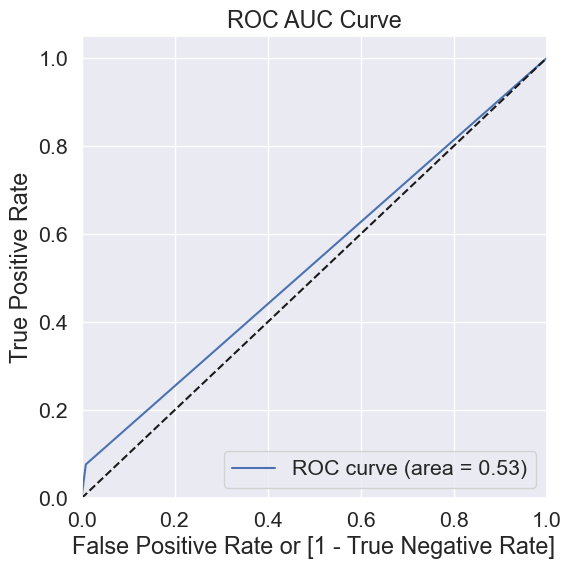

In [95]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

#### 8.6. Model 3. Decision Tree with PCA and GridSearchCV

In [96]:
dt = DecisionTreeClassifier(random_state=42)

In [97]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)

In [98]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    scaler,
    pca,
    dt
)

In [99]:
# Create the parameter grid based on the results of random search 
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
}

In [100]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [101]:
# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             scoring='accuracy', verbose=1)

In [102]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Predict on train set using the best model
y_train_pred = grid_search.predict(X_train)

# Predict on validation set using the best model
y_val_pred = grid_search.predict(X_val)

In [103]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[49407   852]
 [ 4263  1477]]


,Metric,Value
0,Accuracy,0.9087
1,Sensitivity,0.2573
2,Specificity,0.9830
3,Precision,0.6342
4,False Positive Rate,0.0170
5,True Positive Rate,0.2573


In [104]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[12368   240]
 [ 1088   304]]


,Metric,Value
0,Accuracy,0.9051
1,Sensitivity,0.2184
2,Specificity,0.9810
3,Precision,0.5588
4,False Positive Rate,0.0190
5,True Positive Rate,0.2184


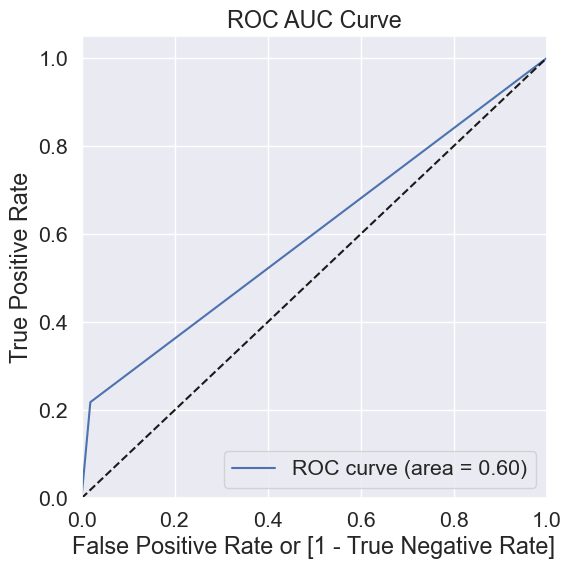

In [105]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

#### 8.7. Model 4. Random Forest Classifier with PCA and Hyperparameter Tuning

In [106]:
rf = RandomForestClassifier(random_state=42)

In [107]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    scaler,
    pca,
    rf
)

In [108]:
# Define the hyperparameters grid for Random Forest
param_grid = {
    'randomforestclassifier__n_estimators': [100],  
    'randomforestclassifier__max_depth': [5, 10],       
    'randomforestclassifier__min_samples_split': [2, 5, 10],
}

In [109]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [110]:
%%time
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 34.5 s
Wall time: 2min 33s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100]},
             scoring='accuracy', verbose=1)

In [111]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_val)

Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 100}


In [112]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[50121   138]
 [ 4649  1091]]


,Metric,Value
0,Accuracy,0.9145
1,Sensitivity,0.1901
2,Specificity,0.9973
3,Precision,0.8877
4,False Positive Rate,0.0027
5,True Positive Rate,0.1901


In [113]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[12368   240]
 [ 1088   304]]


,Metric,Value
0,Accuracy,0.9051
1,Sensitivity,0.2184
2,Specificity,0.9810
3,Precision,0.5588
4,False Positive Rate,0.0190
5,True Positive Rate,0.2184


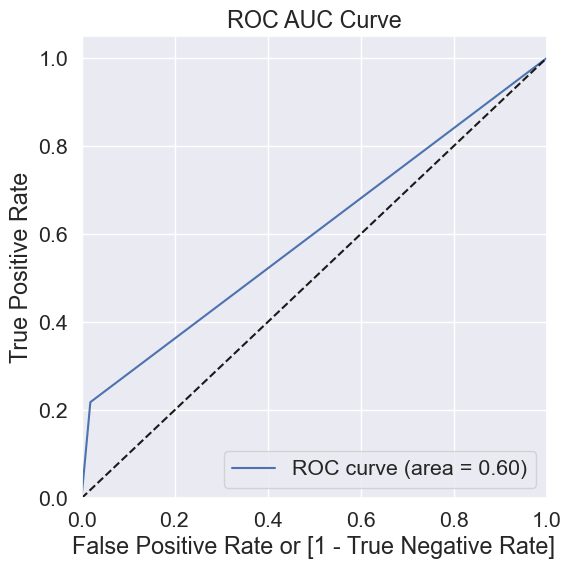

In [114]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [115]:
#### 8.8. Model 5. AdaBoost Classifier

In [116]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    scaler,
    pca,
    AdaBoostClassifier(n_estimators=200, random_state=42)
)

In [117]:
# Build the model
adaboost_model = pipe.fit(X_train, y_train)

In [118]:
# Predict on train set using the best model
y_train_pred = adaboost_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = adaboost_model.predict(X_val)

In [119]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[49236  1023]
 [ 4324  1416]]


,Metric,Value
0,Accuracy,0.9045
1,Sensitivity,0.2467
2,Specificity,0.9796
3,Precision,0.5806
4,False Positive Rate,0.0204
5,True Positive Rate,0.2467


In [120]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[12368   240]
 [ 1088   304]]


,Metric,Value
0,Accuracy,0.9051
1,Sensitivity,0.2184
2,Specificity,0.9810
3,Precision,0.5588
4,False Positive Rate,0.0190
5,True Positive Rate,0.2184


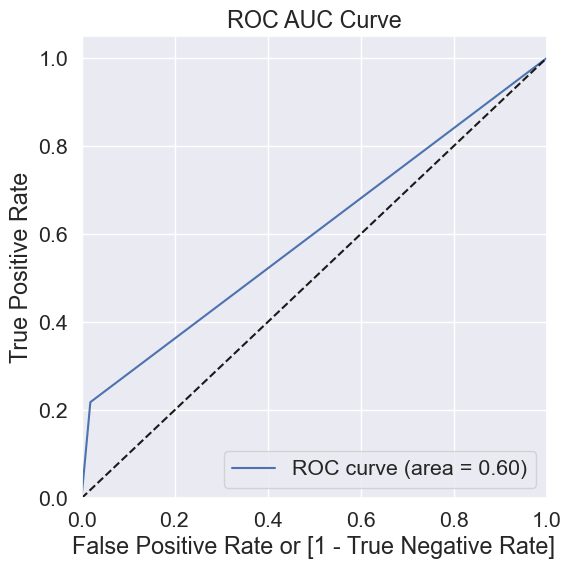

In [121]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

### 9. Create submission.csv file for final submission on Kaggle

### Collating the various metrics
LR with RFE
0	Accuracy	0.9238

LR PCA
0	Accuracy	0.8979

DT with PCA
0	Accuracy	0.9123

RFC with PCA
0	Accuracy	0.9151

AdaBoost
0	Accuracy	0.9041


In [122]:
## Test data

# Transform unseen data set
X_test_scaled = pd.DataFrame(scaler.transform(test_final), columns = test_final.columns, index = test_final.index)

In [123]:
X_test_scaled.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,arpu_6,arpu_7,arpu_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,night_pck_user_6_0.0,night_pck_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_8_0.0,night_pck_user_8_1.0,fb_user_6_0.0,fb_user_6_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_8_0.0,fb_user_8_1.0
0,-0.341475,-0.366634,-0.354784,-0.446407,-0.514068,-0.503192,-0.169726,-0.127351,-0.132236,-0.196755,-0.169660,-0.150952,-0.142309,-0.164902,-0.156257,-0.459179,-0.514192,-0.541414,-0.283474,0.752996,-0.280647,-0.207048,-0.174588,-0.219845,-0.394260,-0.385065,-0.450364,-0.294365,-0.317002,-0.309950,-0.189714,-0.318686,-0.244293,-0.134575,-0.126122,-0.135167,-0.318945,-0.417348,-0.365187,-0.027989,-0.026698,-0.029214,-0.258717,-0.223745,-0.294030,-0.092089,-0.014309,-0.0146,-0.123253,-0.065224,-0.174991,-0.573026,-0.612956,-0.597621,-0.302410,-0.291155,-0.301335,-0.499654,-0.484779,-0.540778,-0.188464,-0.179844,-0.190588,-0.271270,-0.254334,-0.216820,-0.12575,-0.132979,-0.126212,-0.319254,-0.299444,-0.275080,2.877129,2.205005,2.379861,-0.118898,-0.129142,-0.133830,-0.072309,-0.076247,-0.081551,-0.558567,-0.604699,-0.591690,-0.460924,-0.538190,-0.513186,-0.547850,-0.535862,-0.564843,-0.363473,-0.382929,-0.447131,-0.544110,-0.554642,-0.599027,-0.445583,-0.610728,-0.619811,-0.338057,-0.305523,-0.613925,-0.352579,-0.35393,-0.355083,-0.406864,-0.411383,-0.414802,-0.310307,-0.314414,-0.320232,-0.215464,-0.209382,-0.209032,-0.379001,-0.388028,-0.389927,-0.248675,-0.243972,-0.23686,-0.218024,-0.22973,-0.23424,-0.213167,-0.213324,-0.223019,-0.229139,-0.224485,-0.234591,-0.570942,-0.577755,-0.588103,-0.268239,-0.273015,-0.269532,-0.262939,-0.268468,-0.27573,-0.209883,-0.201927,-0.212607,-0.128093,-0.127708,-0.124883,-0.571648,-0.577412,-0.585055,0.497044,-0.252737,-0.246090,-0.230440,-0.570071,-0.078849,-0.576972,-0.076993,-0.587475,-0.073144,-0.146779,-0.547093,-0.153373,-0.550646,-0.171003,-0.5

In [124]:
submission_data = X_test_scaled[selected_features]
submission_data.shape

(30000, 20)

In [125]:
unseen_id = pd.read_csv("test.csv")

In [126]:
X_test_scaled['churn_probability'] = logreg.predict(submission_data)

output_logreg = pd.DataFrame({'id':unseen_id['id'], 'churn_probability': X_test_scaled['churn_probability']})
print(output_logreg.head())
print(output_logreg.shape)

output_logreg.to_csv('submission_logreg.csv',index=False)

      id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0
(30000, 2)


In [127]:
X_test_scaled['churn_probability'] = lr_grid_search.predict(test_final)

output_lr_grid_search = pd.DataFrame({'id':unseen_id['id'], 'churn_probability': X_test_scaled['churn_probability']})
print(output_lr_grid_search.head())
print(output_lr_grid_search.shape)

output_lr_grid_search.to_csv('submission_lr_grid_search.csv',index=False)

      id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0
(30000, 2)


In [128]:
X_test_scaled['churn_probability'] = grid_search.predict(test_final)

output_pca_grid_search = pd.DataFrame({'id':unseen_id['id'], 'churn_probability': X_test_scaled['churn_probability']})
print(output_pca_grid_search.head())
print(output_pca_grid_search.shape)

output_pca_grid_search.to_csv('submission_pca_grid_search.csv',index=False)

      id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0
(30000, 2)


In [129]:
X_test_scaled['churn_probability'] = best_model.predict(test_final)

output_pca_rf = pd.DataFrame({'id':unseen_id['id'], 'churn_probability': X_test_scaled['churn_probability']})
print(output_pca_rf.head())
print(output_pca_rf.shape)

output_pca_rf.to_csv('submission_pca_rf.csv',index=False)

      id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0
(30000, 2)


In [130]:
X_test_scaled['churn_probability'] = adaboost_model.predict(test_final)

output_adaboost = pd.DataFrame({'id':unseen_id['id'], 'churn_probability': X_test_scaled['churn_probability']})
print(output_adaboost.head())
print(output_adaboost.shape)

output_adaboost.to_csv('submission_adaboost.csv',index=False)

      id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0
(30000, 2)


### 10. Business Recommendations
Based on the analysis of our logistic regression model with RFE, here are some business ideas to improve churn rate:

1. Roaming Offers: Provide personalized roaming packages to frequent roamers.
2. Local Call Promotions: Offer competitive rates and bonuses for local calls.
3. Data Recharge Strategies: Promote data packs with targeted marketing campaigns.
4. High-Value Recharge Incentives: Offer discounts for high-value recharges to retain customers.
5. Service Engagement Initiatives: Enhance engagement through loyalty programs and personalized offers.
6. Retention Campaigns: Target customers with low recharge activity with special offers.
7. Non-Data User Promotions: Encourage non-data users to try data services with bundle offers.
8. Night Pack Revival: Revive night pack usage through attractive offers and incentives.Implementing these strategies can effectively reduce churn and improve customer retention in your telecom business.

### 11. Summary
After experimenting with various models, including Logistic Regression with Recursive Feature Elimination (RFE), Logistic Regression with hyperparameter tuning, and PCA, as well as Decision Tree, Random Forest, Adaboost, it's evident that only Logistic Regression with PCA consistently demonstrates the highest sensitivity in both the train and validation sets. Consequently, this model should be considered as the final choice. Other models, although showing promising accuracy in the training phase, perform poorly on the test set, suggesting overfitting.

In the context of telecom churn, where minimizing churn rate is crucial, sensitivity emerges as the most pertinent metric. Hence, based on this criterion, the Logistic Regression model with PCA stands out as the most suitable choice among all alternatives.

### 12. Important features - Logistic Regression with PCA


In [131]:
feature_coefficients = lr_best_estimator.named_steps['logisticregression'].coef_
feature_coefficients

array([[-0.22390903, -0.18842274, -0.14550913,  0.10185996,  0.0510389 ,
        -0.10679804, -0.20841722, -0.04027656, -0.13742648, -0.48630531,
         0.06503944, -0.17434052,  0.17444882,  0.06552416, -0.0334741 ,
         0.03256739,  0.05568794, -0.28514123, -0.14492219, -0.08239286]])

In [132]:
for i, component in enumerate(feature_coefficients[0]):
    print(f"PC{i+1}: {component}")

PC1: -0.2239090314658591
PC2: -0.18842274023600827
PC3: -0.14550912620973766
PC4: 0.10185995667796871
PC5: 0.051038904114851194
PC6: -0.10679803781037694
PC7: -0.20841722216887743
PC8: -0.0402765609670481
PC9: -0.13742647941140676
PC10: -0.486305313682577
PC11: 0.06503943524215669
PC12: -0.1743405218048509
PC13: 0.1744488175899284
PC14: 0.06552416276513989
PC15: -0.03347409700959299
PC16: 0.03256738926892555
PC17: 0.055687938606951884
PC18: -0.28514122720518137
PC19: -0.14492218594558037
PC20: -0.08239285760012499
